<a href="https://colab.research.google.com/github/mrch-hub/bangkit1/blob/test_nn_2/SolarPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Solar radiation intensity prediction using TensorFlow

In [39]:
"""A python code for predicting solar radiation
intensity using TensorFlow. Created for 
5th Bangk!t assignment.
Collaborators: Marcellinus Chrisnada, Muhammad
Harits Hafidza, Mochammad Randy Caesario H."""

'A python code for predicting solar radiation\nintensity using TensorFlow. Created for \n5th Bangk!t assignment.\nCollaborators: Marcellinus Chrisnada, Muhammad\nHarits Hafidza, Mochammad Randy Caesario H.'

##Initialization

In [0]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [41]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# Adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


In [42]:
#@title Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/mrch-hub/bangkit1/master/SolarPrediction.csv')
data.head(40)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.2,48,30.5,59,177.4,5.6,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.2,48,30.5,58,176.8,3.4,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.2,48,30.5,57,158.8,3.4,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.2,48,30.5,60,137.7,3.4,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.2,48,30.5,62,105.0,5.6,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
35,1475218820,9/29/2016 12:00:00 AM,21:00:20,1.2,50,30.5,92,157.5,4.5,06:13:00,18:13:00
36,1475218518,9/29/2016 12:00:00 AM,20:55:18,1.2,50,30.5,91,112.3,7.9,06:13:00,18:13:00
37,1475218220,9/29/2016 12:00:00 AM,20:50:20,1.2,50,30.5,90,133.7,6.8,06:13:00,18:13:00
38,1475217924,9/29/2016 12:00:00 AM,20:45:24,1.2,50,30.5,88,140.6,6.8,06:13:00,18:13:00


##Adding some features to the dataset

In [0]:
#@title Adding feature is_daylight that define measurement time is either daylight (1) or nighttime (0)
is_daylight = [data['Time'].values[x] > data['TimeSunRise'].values[x] and data['Time'].values[x] < data['TimeSunSet'].values[x] for x in range(len(data))]
data['is_daylight'] = is_daylight
data['is_daylight'] = data['is_daylight'].astype('float')

In [0]:
#@title Convert UNIXTime into hour, day, month format
data['Time_Convert'] = pd.to_datetime(data['Time'], format = '%H:%M:%S')

data['Hour'] = pd.to_datetime(data['Time_Convert'], format = '%H:%M:%S').dt.hour # Get the hour of the day

data['Day'] = pd.to_datetime(data['UNIXTime'].astype(int), unit = 's').dt.day # Get the day of the month

data['Month'] = pd.to_datetime(data['UNIXTime'].astype(int), unit = 's').dt.month # Get the month of the year

##Data Preconditioning

In [45]:
#@title Splitting data to train set and test set
data['Data'] = pd.to_datetime(data['Data'])
data = data.sort_values(by = ['Data', 'Time'], ascending=False)
# Percentage of train set to be considered as test set
test_split = 0.2
data_testunshuffled = data[:][0:round((len(data)*test_split))]
data_trainunshuffled = data[:][round((len(data)*test_split)):]
# Shuffle training dataset
data_train = data_trainunshuffled.reindex(np.random.permutation(data_trainunshuffled.index))
data_test = data_testunshuffled.reindex(np.random.permutation(data_testunshuffled.index))
print('train set length:', str(len(data_train)), '\ntest set length:', 
      str(len(data_test)))

train set length: 26149 
test set length: 6537


In [46]:
#@title Normalize values 

# Calculate the Z-scores of each column in the training set:
data_train_mean = data_train.select_dtypes(include=['float64', 'int64']).mean()
data_train_std = data_train.select_dtypes(include=['float64', 'int64']).std()
data_train_norm = (data_train.select_dtypes(include=['float64', 'int64']) 
                   - data_train_mean)/data_train_std
data_train_norm['WindDirection'] = data_train_norm['WindDirection(Degrees)']

# Calculate the Z-scores of each column in the test set.
data_test_mean = data_test.select_dtypes(include=['float64', 'int64']).mean()
data_test_std = data_test.select_dtypes(include=['float64', 'int64']).std()
data_test_norm = (data_test.select_dtypes(include=['float64', 'int64'])
                  - data_test_mean)/data_test_std
data_test_norm['WindDirection'] = data_test_norm['WindDirection(Degrees)']


print("Normalized the values.")

Normalized the values.


## Represent data

The following code cell creates a feature layer containing these features:

* `Temperature`
* `Pressure`
* `is_daylight`
* `Day`
* `Hour`
* `Month`
* `Humidity`
* `WindDirection`

In [0]:
# Create empty feature column list
feature_columns = []

# Represent Temperature as a floating-point value.
temperature = tf.feature_column.numeric_column("Temperature")
feature_columns.append(temperature)

# Represent Pressure as a floating-point value.
pressure = tf.feature_column.numeric_column("Pressure")
feature_columns.append(pressure)

# Represent Daylight as a floating-point value.
daylight = tf.feature_column.numeric_column("is_daylight")
feature_columns.append(daylight)

# Unrepresent Day as a floating-point value.
#day = tf.feature_column.numeric_column("Day")
#feature_columns.append(day)

# Represent Hour as a floating-point value.
hour = tf.feature_column.numeric_column("Hour")
feature_columns.append(hour)

# Unrepresent Month as a floating-point value.
#month = tf.feature_column.numeric_column("Month")
#feature_columns.append(month)

# Represent Humidity as a floating-point value.
humidity = tf.feature_column.numeric_column("Humidity")
feature_columns.append(humidity)

# Represent WindDirection as a floating-point value.
windir = tf.feature_column.numeric_column("WindDirection")
feature_columns.append(windir)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## Build a linear regression model

In [48]:
#@title Define plotting function

def plot_the_loss_curve(epochs, rmse_training, rmse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs[1:], rmse_training[1:], label="Training Loss")
  plt.plot(epochs[1:], rmse_validation[1:], label="Validation Loss")
  plt.legend()

  merged_rmse_lists = rmse_training[1:] + rmse_validation[1:]
  highest_loss = max(merged_rmse_lists)
  lowest_loss = min(merged_rmse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [49]:
#@title Define functions to create and train a linear regression model
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name,validation_split):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=validation_split, 
                      shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, history.history   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

21/21 [==============================] - 0s 11ms/step - loss: 1.8358 - root_mean_squared_error: 1.3556 - val_loss: 1.2996 - val_root_mean_squared_error: 1.1447
Epoch 2/50
21/21 [==============================] - 0s 5ms/step - loss: 1.0479 - root_mean_squared_error: 1.0240 - val_loss: 0.8729 - val_root_mean_squared_error: 0.9405
Epoch 3/50
21/21 [==============================] - 0s 5ms/step - loss: 0.7502 - root_mean_squared_error: 0.8664 - val_loss: 0.6691 - val_root_mean_squared_error: 0.82

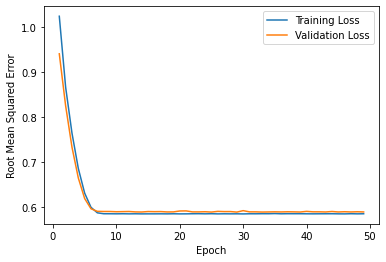


 Evaluate the linear regression model against the test set:
7/7 [==============================] - 0s 3ms/step - loss: 0.4142 - root_mean_squared_error: 0.6406


[0.4141795337200165, 0.6405974626541138]

In [50]:
#@title Train the model as linear regression
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 50
batch_size = 1000
validation_split = 0.2
label_name = "Radiation"
 

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, data_train_norm, epochs, batch_size, label_name, 
                          validation_split=validation_split)
plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

test_features = {name:np.array(value) for name, value in data_test_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

##Build a neural net model

In [0]:
#@title Define functions to create and train a neural net model
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 10 nodes.   
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='sigmoid',
                                  name='Hidden1'))
  
  # Define the second hidden layer with 5 nodes. 
  model.add(tf.keras.layers.Dense(units=5, 
                                  activation='sigmoid', 
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

def train_model(model, dataset, epochs, label_name,
                batch_size, validation_split):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=validation_split, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, history.history 

Epoch 1/1200
10/10 [==============================] - 0s 23ms/step - loss: 1.4880 - root_mean_squared_error: 1.2251 - val_loss: 1.1547 - val_root_mean_squared_error: 1.0719
Epoch 2/1200
10/10 [==============================] - 0s 9ms/step - loss: 1.0021 - root_mean_squared_error: 1.0041 - val_loss: 0.9486 - val_root_mean_squared_error: 0.9721
Epoch 3/1200
10/10 [==============================] - 0s 10ms/step - loss: 0.8999 - root_mean_squared_error: 0.9463 - val_loss: 0.8985 - val_root_mean_squared_error: 0.9465
Epoch 4/1200
10/10 [==============================] - 0s 9ms/step - loss: 0.8604 - root_mean_squared_error: 0.9270 - val_loss: 0.8632 - val_root_mean_squared_error: 0.9281
Epoch 5/1200
10/10 [==============================] - 0s 9ms/step - loss: 0.8201 - root_mean_squared_error: 0.9068 - val_loss: 0.8220 - val_root_mean_squared_error: 0.9058
Epoch 6/1200
10/10 [==============================] - 0s 9ms/step - loss: 0.7813 - root_mean_squared_error: 0.8832 - val_loss: 0.7781 - va

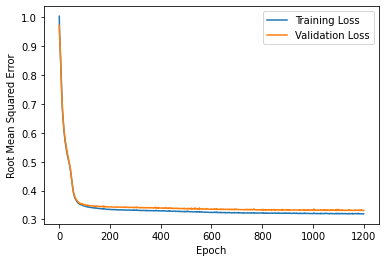


 Evaluate the linear regression model against the test set:
4/4 [==============================] - 0s 3ms/step - loss: 0.2693 - root_mean_squared_error: 0.5079


[0.26933053135871887, 0.5078767538070679]

In [52]:
#@title Train the model
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 1200
batch_size = 2048
validation_split = 0.25
label_name = "Radiation"
 

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, data_train_norm, epochs, label_name, batch_size, 
                          validation_split)
plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

test_features = {name:np.array(value) for name, value in data_test_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

In [53]:
prediction = my_model.predict(test_features, batch_size = 2048)
prediction = [(prediction[i]*data_test_std['Radiation']) + data_test_mean['Radiation'] for i in range (len(prediction))]

print('Compare the first 10 values between actual values and predicted values\n')
for i in range (10):
  print('\n------------------', i, '-----------------------\n')
  print('Actual Value : ', data_test['Radiation'].values[i])
  print('Predicted Value : ', prediction[i])

Compare the first 10 values between actual values and predicted values


------------------ 0 -----------------------

Actual Value :  1.31
Predicted Value :  [-10.212051]

------------------ 1 -----------------------

Actual Value :  46.43
Predicted Value :  [285.90448]

------------------ 2 -----------------------

Actual Value :  1.22
Predicted Value :  [-9.721893]

------------------ 3 -----------------------

Actual Value :  120.52
Predicted Value :  [797.1324]

------------------ 4 -----------------------

Actual Value :  866.94
Predicted Value :  [776.95496]

------------------ 5 -----------------------

Actual Value :  933.38
Predicted Value :  [623.22504]

------------------ 6 -----------------------

Actual Value :  1.23
Predicted Value :  [-9.314087]

------------------ 7 -----------------------

Actual Value :  338.03
Predicted Value :  [693.0792]

------------------ 8 -----------------------

Actual Value :  1.25
Predicted Value :  [-8.0009]

------------------ 9 ---------

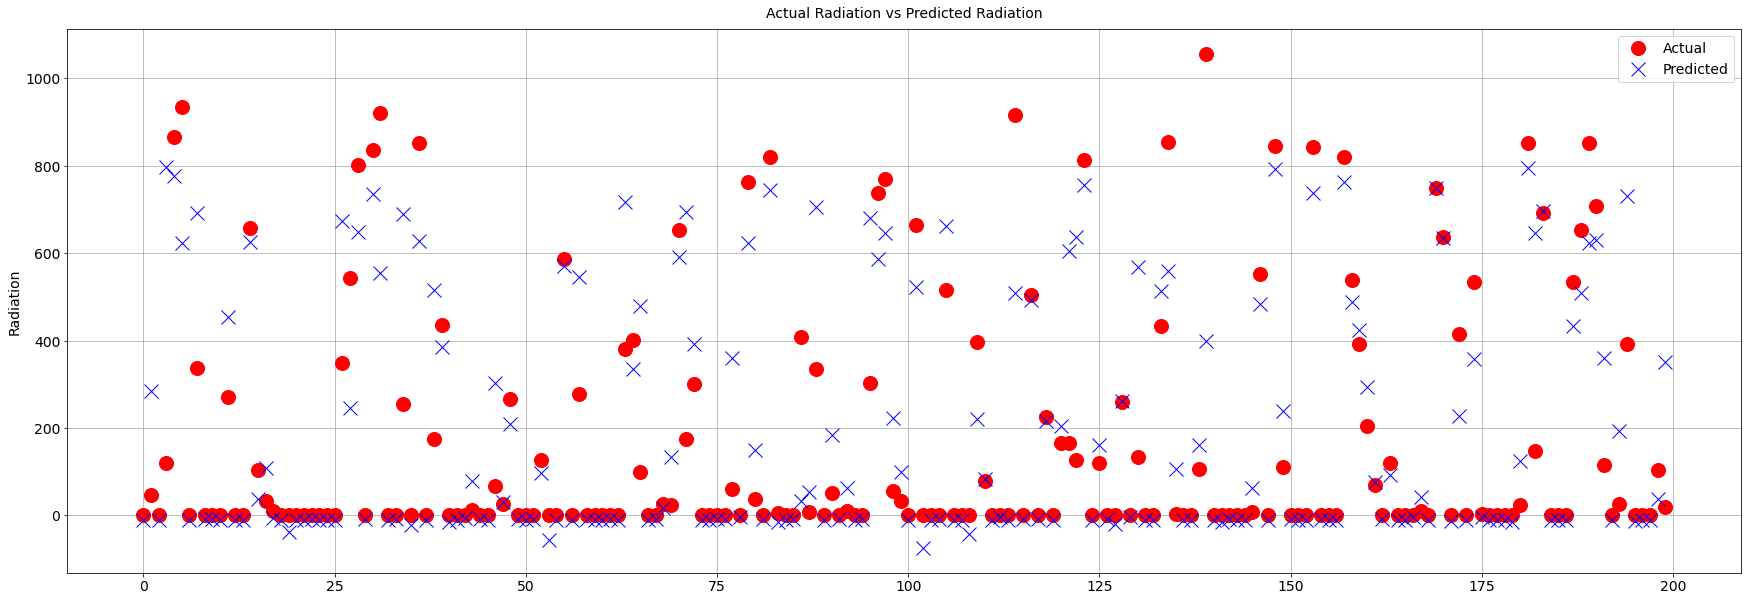

In [66]:
x_value = [i for i in range (200)]
plt.figure(figsize = (30,10))
plt.plot(x_value, data_test['Radiation'].values[0:200], 'ro', markersize = 14 ,label = 'Actual')
plt.plot(x_value, prediction[0:200], 'bx', markersize = 14, label = 'Predicted')
plt.legend(prop={'size': 14})
plt.title('Actual Radiation vs Predicted Radiation', fontsize = 14, y = 1.01)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Radiation', fontsize = 14)
plt.grid()